In [1]:
import pandas as pd
import datetime
import requests
import json
import sys, os
import itertools
import time
import numpy as np
from os import path
from pathlib import Path
from binance.spot import Spot
from twelvedata import TDClient
from sklearn import metrics
from sklearn.inspection import permutation_importance
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import itertools
import xgboost as xgb
import seaborn as sns
from typing import Union, Dict, List
import talib
import ta
import shap
from coinmetrics.api_client import CoinMetricsClient
sys.path.insert(0, os.path.join(os.getcwd(), ".."))
import fin_utilities 
import sklearn
import scikitplot as skplt
import matplotlib.pyplot as plt
cfg = fin_utilities.__cfg_reading("pred")
import my_functions
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense,BatchNormalization
from keras.layers import Dropout, Activation
from keras import regularizers, initializers
from sklearn.preprocessing import MinMaxScaler
from keras.layers import TimeDistributed


import matplotlib as mpl
# Set the default color cycle
mpl.rcParams.update(mpl.rcParamsDefault)


#td = TDClient(apikey=cfg['TWELVEDATA']['API'])  

PROJECT_DIR = eval(cfg['PROJECT_PATH'])
DATA_PATH   = PROJECT_DIR / cfg['DATA_FOLDER']
SOURCE      = cfg['API_DATA_SOURCE']
URL         = cfg[SOURCE]['API_URL_HIST_DATA']
COLUMNS     = cfg[SOURCE]['COLUMN_NAMES']
PARAMS      = cfg[SOURCE]['REQ_PARAMS']
SYMBOL      = cfg['SYMBOL']
STABLECOIN  = cfg['STABLECOIN']
MAX_LENGTH  = cfg['MAX_TRADE_DURATION']
XGB_PARAM   = cfg['xgb']
TEST_SIZE   = 100
client = CoinMetricsClient()
print(client)


In [3]:
tmp = pd.read_csv('data/SKY_Sottoscrizioni_2022.csv')
tmp.head()

ParserError: Error tokenizing data. C error: Expected 1 fields in line 1822, saw 2


In [2]:
def extract_values(dict_list, key):
    """
    Extracts the values associated with a given key from a list of dictionaries.

    Args:
        dict_list (list): A list of dictionaries.
        key (str): The key to extract the value from.

    Returns:
        list: A list of values associated with the key.
    """
    values = []
    for dictionary in dict_list:
        if key in dictionary:
            values.append(dictionary[key])
    return values


def create_dict(list1, list2):
    """
    Given two lists, create a dictionary with keys from list1 and values from list2

    Args:
        list1 (list): The list of keys for the dictionary.
        list2 (list): The list of values for the dictionary.

    Returns:
        dict: A dictionary with keys from list1 and values from list2, intercepted with available metrics
    """
    result_dict = {}
    for key in list1:
        result_dict[key] = list(set(extract_values(client.catalog_assets(key)[0]['metrics'], 'metric')) & set(list2))
    return result_dict


In [5]:
import pandas as pd
from openbb_terminal.sdk import openbb
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import datetime
import sys, os
import sys
from datetime import date, datetime, timedelta
from multiprocessing import Pool
from os import environ, makedirs, remove
from os.path import exists
from pathlib import Path
from typing import Optional
from coinmetrics.api_client import CoinMetricsClient
from coinmetrics.constants import PagingFrom
import numpy as np
from os import path
from pathlib import Path
from binance.spot import Spot
from sklearn import metrics
from sklearn.inspection import permutation_importance
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import itertools
import xgboost as xgb
import seaborn as sns
from typing import Union, Dict, List
from scipy import optimize
from scipy import special


#############################################################################################################################################################################
# GET DATA FROM ALL THE EXHANGES ############################################################################################################################################
#############################################################################################################################################################################
                                                                                                                                                                            #
def export_data(client,                                                                                                                                                     #
                PROCESSED_DAYS_REGISTRY_FILE_PATH,                                                                                                                          #
                EXCHANGES_TO_EXPORT,                                                                                                                                        #
                MARKETS_TO_EXPORT,                                                                                                                                          #
                MARKET_TYPES_TO_COLLECT,                                                                                                                                    #
                BASE_MARKETS,                                                                                                                                               #
                QUOTE_MARKETS,                                                                                                                                              #
                EXPORT_START_DATE,                                                                                                                                          #
                EXPORT_END_DATE,                                                                                                                                            #
                DST_ROOT,                                                                                                                                                   #
                FREQUENCY                                                                                                                                                   #
):                                                                                                                                                                          #
                                                                                                                                                                            #
    min_export_date = date.fromisoformat(EXPORT_START_DATE)                                                                                                                 #
    max_export_date = (                                                                                                                                                     #
        date.fromisoformat(EXPORT_END_DATE)                                                                                                                                 #
        if EXPORT_END_DATE is not None                                                                                                                                      #
        else date.today() - timedelta(days=1)                                                                                                                               #
    )                                                                                                                                                                       #
    processed_dates_and_markets = read_already_processed_files(PROCESSED_DAYS_REGISTRY_FILE_PATH)                                                                           #
                                                                                                                                                                            #
    markets = get_markets_to_process(client,EXCHANGES_TO_EXPORT, MARKETS_TO_EXPORT, MARKET_TYPES_TO_COLLECT, BASE_MARKETS, QUOTE_MARKETS)                                   #
    print("getting markets: %s", [market["market"] for market in markets])                                                                                                  #
    processes_count = 2                                                                                                                                                     #
                                                                                                                                                                            #
    if processes_count > 2:                                                                                                                                                 #
        print(                                                                                                                                                              #
            "Using more than two parallel processes will likely not result into faster export."                                                                             #
        )                                                                                                                                                                   #
                                                                                                                                                                            #
    with Pool(processes_count) as pool:                                                                                                                                     #
        tasks = []                                                                                                                                                          #
        for market in markets:                                                                                                                                              #
            market_data_root = "/".join(                                                                                                                                    #
                (                                                                                                                                                           #
                    DST_ROOT.rstrip("/"),                                                                                                                                   #
                    market["market"].split("-")[0],                                                                                                                         #
                    get_instrument_root(market),                                                                                                                            #
            )                                                                                                                                                               #
                )                                                                                                                                                           #
                                                                                                                                                                            #
            # creating all the directories upfront to not to call this function in export function for each day                                                             #
            # otherwise it can fail in the multiproc environment even with exist_ok=True.                                                                                   #
            makedirs(market_data_root, exist_ok=True)                                                                                                                       #
                                                                                                                                                                            #
            if FREQUENCY in {"1h", "4h", "1d"}:                                                                                                                             #
                if (                                                                                                                                                        #
                                                                                                                                                                            #
                    get_registry_key(market, min_export_date)                                                                                                               #
                    not in processed_dates_and_markets                                                                                                                      #
                ):                                                                                                                                                          #
                    tasks.append(                                                                                                                                           #
                            export_data_for_a_market                                                                                                                        #
                            (                                                                                                                                               #
                                client,                                                                                                                                     #
                                market,                                                                                                                                     #
                                market_data_root,                                                                                                                           #
                                min_export_date,                                                                                                                            #
                                max_export_date,                                                                                                                            #
                                FREQUENCY, PROCESSED_DAYS_REGISTRY_FILE_PATH                                                                                                #
                            )                                                                                                                                               #
                                                                                                                                                                            #
                    )                                                                                                                                                       #
            else:                                                                                                                                                           #
                for target_date in get_days_to_export(                                                                                                                      #
                    market, min_export_date, max_export_date                                                                                                                #
                ):                                                                                                                                                          #
                    if (                                                                                                                                                    #
                        get_registry_key(market, target_date)                                                                                                               #
                        not in processed_dates_and_markets                                                                                                                  #
                    ):                                                                                                                                                      #
                        tasks.append(                                                                                                                                       #
                            pool.apply_async(                                                                                                                               #
                                export_data_for_a_market,                                                                                                                   #
                                (client,market, market_data_root, target_date, target_date,FREQUENCY, PROCESSED_DAYS_REGISTRY_FILE_PATH),                                   #
                            )                                                                                                                                               #
                        )                                                                                                                                                   #
                                                                                                                                                                            #
        start_time = datetime.utcnow()                                                                                                                                      #
                                                                                                                                                                            #
        for i, task in enumerate(tasks, 1):                                                                                                                                 #
            try:                                                                                                                                                            #
                task.get()                                                                                                                                                  #
            except Exception:                                                                                                                                               #
                print(f'failed to get data for task {task}')                                                                                                                #
            time_since_start = datetime.utcnow() - start_time                                                                                                               #
            print("processed task: %s/%s, time since start: %s, completion ETA:: %s",                                                                                       #
                        i, len(tasks), time_since_start, time_since_start / i * (len(tasks) - i))                                                                           #
                                                                                                                                                                            #
                                                                                                                                                                            #
#############################################################################################################################################################################
                                                                                                                                                                            #
def get_instrument_root(market):                                                                                                                                            #
    if market["type"] == "spot":                                                                                                                                            #
        return "{}_{}_{}".format(market["base"], market["quote"], market["type"])                                                                                           #
    return "{}_{}".format(market["symbol"].replace(":", "_"), market["type"])                                                                                               #
                                                                                                                                                                            #
#############################################################################################################################################################################
                                                                                                                                                                            #
def read_already_processed_files(PROCESSED_DAYS_REGISTRY_FILE_PATH):                                                                                                        #
    if exists(PROCESSED_DAYS_REGISTRY_FILE_PATH):                                                                                                                           #
        with open(PROCESSED_DAYS_REGISTRY_FILE_PATH) as registry_file:                                                                                                      #
            return set(registry_file.read().splitlines())                                                                                                                   #
    return set()                                                                                                                                                            #
                                                                                                                                                                            #
#############################################################################################################################################################################
                                                                                                                                                                            #
def get_markets_to_process(client,EXCHANGES_TO_EXPORT, MARKETS_TO_EXPORT, MARKET_TYPES_TO_COLLECT, BASE_MARKETS, QUOTE_MARKETS):                                            #
    markets = []                                                                                                                                                            #
                                                                                                                                                                            #
    for exchange in EXCHANGES_TO_EXPORT or [None]:                                                                                                                          #
        for market in client.catalog_markets(exchange=exchange):                                                                                                            #
            if market["market"] in MARKETS_TO_EXPORT or (                                                                                                                   #
                (market["type"] in MARKET_TYPES_TO_COLLECT)                                                                                                                 #
                and (                                                                                                                                                       #
                    (                                                                                                                                                       #
                        ('base' in market and market["base"] in BASE_MARKETS or not BASE_MARKETS)                                                                           #
                        and (market["quote"] in QUOTE_MARKETS or not QUOTE_MARKETS)                                                                                         #
                    )                                                                                                                                                       #
                )                                                                                                                                                           #
            ):                                                                                                                                                              #
                markets.append(market)                                                                                                                                      #
    return markets                                                                                                                                                          #
                                                                                                                                                                            #
#############################################################################################################################################################################
                                                                                                                                                                            #
def get_days_to_export(market_info, min_export_date, max_export_date):                                                                                                      #
    min_date = max(                                                                                                                                                         #
        date.fromisoformat(market_info["min_time"].split("T")[0]), min_export_date                                                                                          #
    )                                                                                                                                                                       #
    max_date = min(                                                                                                                                                         #
        date.fromisoformat(market_info["max_time"].split("T")[0]), max_export_date                                                                                          #
    )                                                                                                                                                                       #
    for target_date_index in range((max_date - min_date).days + 1):                                                                                                         #
        yield min_date + timedelta(days=target_date_index)                                                                                                                  #
                                                                                                                                                                            #
#############################################################################################################################################################################
                                                                                                                                                                            #
def export_data_for_a_market(client,market, market_data_root, start_date, end_date, FREQUENCY, PROCESSED_DAYS_REGISTRY_FILE_PATH):                                          #
    market_candles = client.get_market_candles(                                                                                                                             #
        market["market"],                                                                                                                                                   #
        start_time=start_date,                                                                                                                                              #
        end_time=end_date,                                                                                                                                                  #
        page_size=10000,                                                                                                                                                    #
        paging_from=PagingFrom.START,                                                                                                                                       #
        frequency=FREQUENCY,                                                                                                                                                #
    )                                                                                                                                                                       #
    if start_date != end_date:                                                                                                                                              #
        dst_csv_file_path = "/".join((market_data_root, "candles")) + f"{FREQUENCY}.csv"                                                                                    #
    else:                                                                                                                                                                   #
        dst_csv_file_path = (                                                                                                                                               #
            "/".join((market_data_root, "candles_" + start_date.isoformat())) + f"{FREQUENCY}.csv"                                                                          #
        )                                                                                                                                                                   #
                                                                                                                                                                            #
    print("downloading data to: %s", dst_csv_file_path)                                                                                                                     #
    market_candles.export_to_csv(dst_csv_file_path)                                                                                                                         #
    # cleanup files without data                                                                                                                                            #
    if Path(dst_csv_file_path).stat().st_size == 0:                                                                                                                         #
        remove(dst_csv_file_path)                                                                                                                                           #
    with open(PROCESSED_DAYS_REGISTRY_FILE_PATH, "a") as registry_file:                                                                                                     #
        registry_file.write(get_registry_key(market, start_date) + "\n")                                                                                                    #
                                                                                                                                                                            #
#############################################################################################################################################################################
                                                                                                                                                                            #
def get_registry_key(market, target_date):                                                                                                                                  #
    return "{},{}".format(market["market"], target_date.isoformat())                                                                                                        #
                                                                                                                                                                            #
#############################################################################################################################################################################

def list_of_all_metrics(client):
    
    metric = []
    full_name = []
    desc = []

    list_metrics = client.catalog_asset_metrics()
    for el in list_metrics:
        metric.append(el['metric'])
        full_name.append(el['full_name'])
        desc.append(el['description'])

    df = pd.DataFrame({'metric':metric, 'full_name':full_name, 'description':desc})
    return df

#############################################################################################################################################################################


def read_data_for_a_market(market_data_root, FREQUENCY):                                                 
                                                                                                                                                               
    dst_csv_file_path = "/".join((market_data_root, "candles")) + f"{FREQUENCY}.csv"                                                                                                
                                                                                                                                                           
    print("reading data from: ", dst_csv_file_path)                                                                                                               
    tmp = pd.read_csv(dst_csv_file_path)                                                                                                                         
    return tmp      

In [9]:
# EXPORT DI TUTTI I DATI DA TUTTI GLI EXCHANGE
from typing import Optional
import logging

logger = logging.getLogger()
stream_handler = logging.StreamHandler()
level = logging.getLevelName("INFO")
stream_handler.level = level
formatter = logging.Formatter(
    datefmt="[%Y-%m-%d %H:%M:%S]", fmt="%(asctime)-15s %(levelname)s %(message)s"
)
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)
logger.level = level

# use it if you want to get specific exchanges or leave it empty if you want to get all exchanges data
EXCHANGES_TO_EXPORT = {}

# use it if you want to get specific markets or leave it empty if you want to get all markets
# example of market name to be used in this filter: "binance-BTCUSDT-future",
# note that if you specified exchanges filter, it will act as selecting intersection with the markets to export
# not as union.
MARKETS_TO_EXPORT = {}

# example values: "spot", "future", "option"
# you can use all 3 if you want or just a subset
MARKET_TYPES_TO_COLLECT = {
    "spot"   
}

# leave it empty to catch all
BASE_MARKETS = {
    "btc",
}

# leave it empty to catch all
QUOTE_MARKETS = {
    "usdt",
}

# 1m, 5m, 10m, 15m, 30m, 1h, 4h, 1d
FREQUENCY = "1h"

DST_ROOT = "./data"
EXPORT_START_DATE = "2013-01-01"
EXPORT_END_DATE: Optional[str] = None
# path to local file that is used to not reexport data if it was already exported
PROCESSED_DAYS_REGISTRY_FILE_PATH = "candles_processed_days_registry.txt"

client = CoinMetricsClient()


my_functions.export_data(
        client,
        PROCESSED_DAYS_REGISTRY_FILE_PATH, 
        EXCHANGES_TO_EXPORT,
        MARKETS_TO_EXPORT,
        MARKET_TYPES_TO_COLLECT,
        BASE_MARKETS,
        QUOTE_MARKETS,
        EXPORT_START_DATE,
        str(datetime.now().date()), 
        DST_ROOT, 
        FREQUENCY 
)


getting markets: %s ['bibox-btc-usdt-spot', 'binance-btc-usdt-spot', 'binance.us-btc-usdt-spot', 'bitfinex-btc-usdt-spot', 'bitstamp-btc-usdt-spot', 'bittrex-btc-usdt-spot', 'bybit-btc-usdt-spot', 'cex.io-btc-usdt-spot', 'coinbase-btc-usdt-spot', 'crypto.com-btc-usdt-spot', 'gate.io-btc-usdt-spot', 'gemini-btc-usdt-spot', 'hitbtc-btc-usdt-spot', 'huobi-btc-usdt-spot', 'kraken-btc-usdt-spot', 'kucoin-btc-usdt-spot', 'lbank-btc-usdt-spot', 'liquid-btc-usdt-spot', 'mexc-btc-usdt-spot', 'okex-btc-usdt-spot', 'poloniex-btc-usdt-spot', 'upbit-btc-usdt-spot', 'zb.com-btc-usdt-spot']
downloading data to: %s ./data/bibox/btc_usdt_spot/candles1h.csv
downloading data to: %s ./data/binance/btc_usdt_spot/candles1h.csv
downloading data to: %s ./data/binance.us/btc_usdt_spot/candles1h.csv
downloading data to: %s ./data/bitfinex/btc_usdt_spot/candles1h.csv
downloading data to: %s ./data/bitstamp/btc_usdt_spot/candles1h.csv
downloading data to: %s ./data/bittrex/btc_usdt_spot/candles1h.csv
downloading 

[2023-03-27 22:42:12] INFO no data to export
[2023-03-27 22:42:12] INFO no data to export
[2023-03-27 22:42:12] INFO no data to export


downloading data to: %s ./data/liquid/btc_usdt_spot/candles1h.csv


[2023-03-27 22:42:12] INFO no data to export
[2023-03-27 22:42:12] INFO no data to export
[2023-03-27 22:42:12] INFO no data to export


downloading data to: %s ./data/mexc/btc_usdt_spot/candles1h.csv
downloading data to: %s ./data/okex/btc_usdt_spot/candles1h.csv
downloading data to: %s ./data/poloniex/btc_usdt_spot/candles1h.csv
downloading data to: %s ./data/upbit/btc_usdt_spot/candles1h.csv
downloading data to: %s ./data/zb.com/btc_usdt_spot/candles1h.csv
failed to get data for task None
processed task: %s/%s, time since start: %s, completion ETA:: %s 1 23 0:00:00.000501 0:00:00.011022
failed to get data for task None
processed task: %s/%s, time since start: %s, completion ETA:: %s 2 23 0:00:00.000544 0:00:00.005712
failed to get data for task None
processed task: %s/%s, time since start: %s, completion ETA:: %s 3 23 0:00:00.000544 0:00:00.003620
failed to get data for task None
processed task: %s/%s, time since start: %s, completion ETA:: %s 4 23 0:00:00.000657 0:00:00.003116
failed to get data for task None
processed task: %s/%s, time since start: %s, completion ETA:: %s 5 23 0:00:00.000657 0:00:00.002358
failed t

In [45]:
#POLYGON HA PROBLEMI CON PROFONDITA STORICA
import requests
response = requests.get('https://api.polygon.io/v2/aggs/ticker/X:BTCUSD/range/1/day/2009-01-01/2023-01-09?adjusted=true&sort=asc&limit=50000&apiKey=t9Hb6jZUizreYPBZWsAFbm8Imn0zdQZU').json()
tmp = pd.DataFrame(response['results'])
tmp['t'] = pd.to_datetime(tmp['t'], unit='ms')
tmp

#COINMETRICS HA PROBLEMI CON DATI CON FREQUENZA NON GIORNALIERA. SERVE API

,v,vw,o,c,h,l,t,n
0,47876.403594,55437.7907,54975,55856.53,56686.15,53948.35,2021-03-27,529899


In [21]:
mkts = my_functions.get_markets_to_process(client,EXCHANGES_TO_EXPORT, MARKETS_TO_EXPORT, MARKET_TYPES_TO_COLLECT, BASE_MARKETS, QUOTE_MARKETS)

asd = pd.DataFrame()

for mkt in mkts:
    print(mkt)
    market_candles = client.get_market_candles(                                                                                                                             #
        mkt["market"],                                                                                                                                                   #
        start_time="2009-01-01",                                                                                                                                              #
        end_time="2023-01-01",                                                                                                                                                  #
        page_size=10000,                                                                                                                                                    #
        paging_from=PagingFrom.START,                                                                                                                                       #
        frequency="1d"                                                                                                                                                #
    )    
    asd = market_candles.to_dataframe()                                                                                                                                                                   #
    break

asd

{'market': 'bibox-btc-usdt-spot', 'min_time': '2023-03-26T21:13:37.000000000Z', 'max_time': '2023-03-27T20:48:54.776000000Z', 'exchange': 'bibox', 'type': 'spot', 'trades': {'min_time': '2023-03-26T21:13:37.000000000Z', 'max_time': '2023-03-27T20:48:54.776000000Z'}, 'base': 'btc', 'quote': 'usdt', 'symbol': 'BTC_USDT'}


,market,time,price_open,price_close,price_high,price_low,vwap,volume,candle_usd_volume,candle_trades_count
0,bibox-btc-usdt-spot,2019-05-02 00:00:00+00:00,5444.98,5495.24,5536.905,5423.13,5493.887066,35186.250541,189645792.872809,51564
1,bibox-btc-usdt-spot,2019-05-03 00:00:00+00:00,5496.09,5769.575,5841.3,5480.0,5713.279629,54369.949946,305843616.476766,95902
2,bibox-btc-usdt-spot,2019-05-04 00:00:00+00:00,5770.2675,5833.4024,5899.9993,5596.44,5772.005927,48163.344901,274219712.36967,94636
3,bibox-btc-usdt-spot,2019-05-05 00:00:00+00:00,5831.7612,5780.1082,5840.2099,5700.44,5780.157177,63359.917565,362457117.513332,109627
4,bibox-btc-usdt-spot,2019-05-06 00:00:00+00:00,5780.1082,5748.855,5809.0243,5627.97,5710.187183,45899.949675,259130926.557247,93855
...,...,...,...,...,...,...,...,...,...,...
342,bibox-btc-usdt-spot,2022-12-28 00:00:00+00:00,16710.7,16551.4,16785.3,16466.0,16624.89978,469.879899,7808380.957729,141217
343,bibox-btc-usdt-spot,2022-12-29 00:00:00+00:00,16551.4,16640.5,16665.2,16500.0,16597.964313,371.026681,6152900.629782,131788
344,bibox-btc-usdt-spot,2022-12-30 00:00:00+00:00,16640.5,16613.1,16652.0,16356.2,16550.988137,482.543432,7977818.600284,126251
345,bibox-btc-usdt-spot,2022-12-31 00:00:00+00:00,16613.1,16545.3,16646.4,16481.3,16585.826727,294.420389,4878012.01075,108037


In [4]:
dxy = pd.read_csv('data/DXY.csv')
dxy = dxy[['Date','Adj Close']]
dxy['Date'] = pd.to_datetime(dxy['Date'])
#inserisco date mancanti
dxy = pd.merge(pd.Series(pd.date_range(dxy['Date'].min(),dxy['Date'].max(),freq='d'), name='Date'), dxy, on='Date', how='left').reset_index(drop=True)
dxy['Dxy_Close'] = np.round(dxy['Adj Close'].ffill(),2)
dxy.drop(columns='Adj Close', inplace=True)
df = pd.merge(df,dxy,left_on='time',right_on='Date',how='left')
df.drop(columns=['Date'],inplace=True)
df

,market,time,price_open,price_close,price_high,price_low,vwap,volume,candle_usd_volume,candle_trades_count,Dxy_Close
0,btc,2013-12-27,777.00,742.43,779.00,694.84,719.137959,1679.63000,1.203333e+06,3052,80.39
1,btc,2013-12-28,710.46,732.42,752.42,672.80,723.941888,4583.78000,3.304529e+06,8343,80.39
2,btc,2013-12-29,699.61,746.28,750.01,690.50,716.646226,4718.43000,3.373881e+06,8617,80.39
3,btc,2013-12-30,715.05,721.52,758.58,710.40,736.373543,4824.67000,3.539129e+06,8838,80.00
4,btc,2013-12-31,721.99,722.58,756.09,698.17,732.001148,4821.72000,3.512753e+06,8748,80.04
...,...,...,...,...,...,...,...,...,...,...,...
3334,btc,2023-02-12,21862.02,21783.54,22090.00,21630.00,21864.202285,204435.65163,4.470708e+09,4561903,103.63
3335,btc,2023-02-13,21782.37,21773.97,21894.99,21351.07,21657.583360,295730.76791,6.409556e+09,6503611,103.35
3336,btc,2023-02-14,21774.63,22199.84,22319.08,21532.77,21931.761918,361958.40109,7.942328e+09,7695927,103.23
3337,btc,2023-02-15,22199.84,24324.05,24380.00,22047.28,22903.486856,375669.16111,8.604291e+09,8335550,103.92


In [6]:
map_ohlc = {'Open':'price_open','High':'price_high','Low':'price_low','Close':'price_close', 'Volume': 'volume', 'Number of trades': 'candle_trades_count'}
lags_relevant = [13,30,99,200]

In [258]:
print(df.columns)
df['AVG_Candle_Price'] = (df[map_ohlc['Open']]+df[map_ohlc['High']]+df[map_ohlc['Low']]+df[map_ohlc['Close']])/4
for lag in lags_relevant:
    df['Close_lag_'+str(lag)+'d'] = df[map_ohlc['Close']].shift(lag)
    df['SMA_Close_'+str(lag)+'d'] = my_functions.rolling_kpi(df,map_ohlc['Close'],lag,'mean', False)
    df[map_ohlc['Number of trades']+'_'+str(lag)+'d'] = my_functions.rolling_kpi(df,map_ohlc['Number of trades'], lag, 'mean', False)
    df['STD_Close_'+str(lag)+'d'] = my_functions.rolling_kpi(df,map_ohlc['Close'],lag,'std', False)
    df['VAR_Close_lag_'+str(lag)+'d'] = df['STD_Close_'+str(lag)+'d']**2

Index(['market', 'time', 'price_open', 'price_close', 'price_high',
       'price_low', 'vwap', 'volume', 'candle_usd_volume',
       'candle_trades_count', 'Dxy_Close'],
      dtype='object')


In [7]:
df = my_functions.labelize_output_according_criterion2(df, map_ohlc, max_trade_length=MAX_LENGTH)
df['signal'] = (df['min_above'].lt(df['min_below'])) & (df['min_above'] <= MAX_LENGTH)
df['signal']=df['signal'].astype(int)
df.drop(columns=['CloseAbovethreshold', 'HighAbovethreshold',
       'LowAbovethreshold', 'OpenAbovethreshold', 'CloseBelowthreshold',
       'HighBelowthreshold', 'LowBelowthreshold', 'OpenBelowthreshold', 'TP',
       'SL', 'min_above', 'min_below'], inplace=True, errors='ignore')
df = df.dropna().reset_index(drop=True)
df.head()

,market,time,price_open,price_close,price_high,price_low,vwap,volume,candle_usd_volume,candle_trades_count,Dxy_Close,signal
0,btc,2013-12-27,777.00,742.43,779.00,694.84,719.137959,1679.63,1.203333e+06,3052,80.39,0
1,btc,2013-12-28,710.46,732.42,752.42,672.80,723.941888,4583.78,3.304529e+06,8343,80.39,0
2,btc,2013-12-29,699.61,746.28,750.01,690.50,716.646226,4718.43,3.373881e+06,8617,80.39,0
3,btc,2013-12-30,715.05,721.52,758.58,710.40,736.373543,4824.67,3.539129e+06,8838,80.00,0
4,btc,2013-12-31,721.99,722.58,756.09,698.17,732.001148,4821.72,3.512753e+06,8748,80.04,1


In [260]:
from sklearn.preprocessing import PowerTransformer

def yeojohntrans(df, feature):   # function to apply transformer and check the distribution with histogram and kdeplot
    
    yeojohnTr = PowerTransformer(standardize=True)   # not using method attribute as yeo-johnson is the default

    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    plt.title("Distribution before Transformation", fontsize=15)
    sns.histplot(df[feature], kde=True, color="red")
    plt.subplot(1,2,2)
    
    df_yeojohn = pd.DataFrame(yeojohnTr.fit_transform(df[feature].values.reshape(-1,1)))
    plt.title("Distribution after Transformation", fontsize=15)
    sns.histplot(df_yeojohn,bins=20, kde=True , legend=False)
    plt.xlabel(feature)
    plt.show()
    
    print(f"Skewness was {round(df[feature],2)} before & is {round(df_yeojohn.skew()[0],2)} after Yeo-johnson transformation.")
    

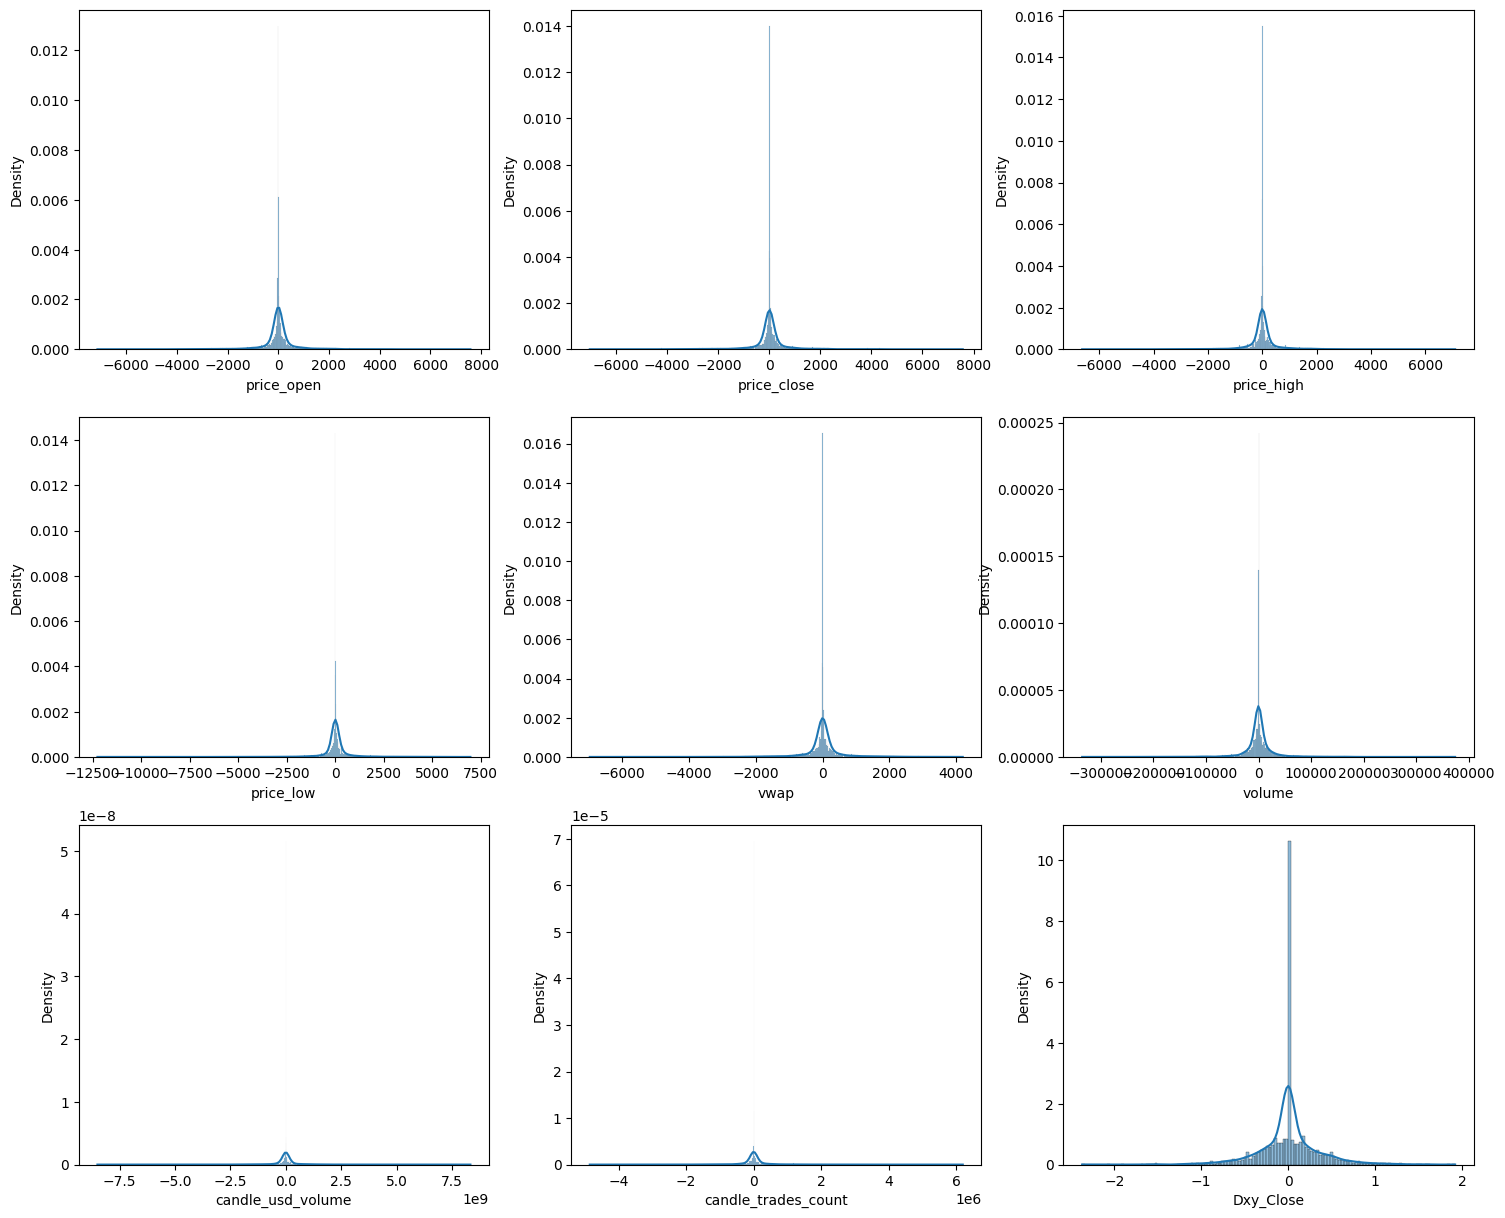

In [8]:
df_analysis = df.copy()

features = [col for col in df_analysis.columns if col not in ['market','time','signal']]
fig, axs = plt.subplots(nrows=int(len(features)/3), ncols=3, figsize=(18,5*int(len(features)/3)))
for i,feature in enumerate(features):
    df_analysis[feature] = df_analysis[feature] - df_analysis[feature].shift()
    single_feature = df_analysis[feature][1:]
    sns.histplot(data=single_feature,kde=True, stat='density', ax=axs[int(i/3)][i%3])

plt.show()


In [212]:
df_btc = df.copy()
df_btc.dropna(inplace=True)
df_btc.drop(columns='market', inplace=True)
df_btc = df_btc.reset_index(drop=True)
df_btc.head()

,time,price_open,price_close,price_high,price_low,vwap,volume,candle_usd_volume,candle_trades_count,Dxy_Close,signal
0,2013-12-27,777.00,742.43,779.00,694.84,719.137959,1679.63,1.203333e+06,3052,80.39,0
1,2013-12-28,710.46,732.42,752.42,672.80,723.941888,4583.78,3.304529e+06,8343,80.39,0
2,2013-12-29,699.61,746.28,750.01,690.50,716.646226,4718.43,3.373881e+06,8617,80.39,0
3,2013-12-30,715.05,721.52,758.58,710.40,736.373543,4824.67,3.539129e+06,8838,80.00,0
4,2013-12-31,721.99,722.58,756.09,698.17,732.001148,4821.72,3.512753e+06,8748,80.04,1


In [213]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [214]:
#df_btc.drop(columns=['price_close','price_high','price_low','candle_usd_volume', 'vwap','volume','candle_trades_count','Dxy_Close'], inplace=True)
df_btc

,time,price_open,price_close,price_high,price_low,vwap,volume,candle_usd_volume,candle_trades_count,Dxy_Close,signal
0,2013-12-27,777.00,742.43,779.00,694.84,719.137959,1679.63000,1.203333e+06,3052,80.39,0
1,2013-12-28,710.46,732.42,752.42,672.80,723.941888,4583.78000,3.304529e+06,8343,80.39,0
2,2013-12-29,699.61,746.28,750.01,690.50,716.646226,4718.43000,3.373881e+06,8617,80.39,0
3,2013-12-30,715.05,721.52,758.58,710.40,736.373543,4824.67000,3.539129e+06,8838,80.00,0
4,2013-12-31,721.99,722.58,756.09,698.17,732.001148,4821.72000,3.512753e+06,8748,80.04,1
...,...,...,...,...,...,...,...,...,...,...,...
3334,2023-02-12,21862.02,21783.54,22090.00,21630.00,21864.202285,204435.65163,4.470708e+09,4561903,103.63,0
3335,2023-02-13,21782.37,21773.97,21894.99,21351.07,21657.583360,295730.76791,6.409556e+09,6503611,103.35,1
3336,2023-02-14,21774.63,22199.84,22319.08,21532.77,21931.761918,361958.40109,7.942328e+09,7695927,103.23,1
3337,2023-02-15,22199.84,24324.05,24380.00,22047.28,22903.486856,375669.16111,8.604291e+09,8335550,103.92,0


In [215]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
features = [col for col in df_btc.columns if col not in ['time','signal']]
#for feature in features:
#     df_btc[feature] = df_btc[feature] - df_btc[feature].shift()
#     df_btc[feature] = np.sqrt(np.absolute(df_btc[feature] - df_btc[feature].shift().fillna(0)))*np.sign(df_btc[feature] - df_btc[feature].shift().fillna(0))

df_btc = df_btc.iloc[1:]

df_btc = my_functions.round_float_cols(df_btc)
df_btc = df_btc.sample(frac=1).reset_index(drop=True)

scaler.fit(df_btc[features][:-TEST_SIZE])

X_train = df_btc[features][:-TEST_SIZE]
X_test = df_btc[features][-TEST_SIZE:]
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [216]:
Y_train = np.array(df_btc['signal'][:-TEST_SIZE])
Y_test = np.array(df_btc['signal'][-TEST_SIZE:])

#X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
#X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(3238, 9)
(100, 9)
(3238,)
(100,)


In [193]:
p = {  
    'eval_metric':'auc',
    'tree_method':'hist',
    'lambda':.01,
    'max_depth':7,
    'scale_pos_weight':5,
    'objective':'binary:logistic',
    'colsample_bytree':.9,
    'eta':0.1,
    'n_estimators':3000,
    'early_stopping_rounds':200
    }

model = my_functions.model_selection('xgb',p)

print(model.get_params())

model.fit(X_train[:-100], Y_train[:-100], eval_set = [(X_train[:-100], Y_train[:-100],), (X_train[-100:], Y_train[-100:],)], verbose=0)
predictions = model.predict_proba(X_train[-100:])[:,1]
fpr_test, tpr_test, _ = sklearn.metrics.roc_curve(Y_train[-100:], predictions)
print("Test set score: {:.5f}".format(sklearn.metrics.auc(fpr_test, tpr_test)))



{'objective': 'binary:logistic', 'use_label_encoder': None, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.9, 'early_stopping_rounds': 200, 'enable_categorical': False, 'eval_metric': 'auc', 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 7, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 3000, 'n_jobs': -1, 'num_parallel_tree': None, 'predictor': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': 5, 'subsample': None, 'tree_method': 'hist', 'validate_parameters': None, 'verbosity': None, 'lambda': 0.01, 'eta': 0.1}
Test set score: 0.66725


BUILD LSTM

In [210]:
from keras.callbacks import EarlyStopping

from keras.layers.core import Dense, Dropout
from keras.optimizers import Adagrad


opt = tf.keras.optimizers.experimental.SGD(learning_rate=.2, weight_decay=0)


model = Sequential()
model.add(LSTM(50, return_sequences=True, activation='relu', input_shape=(X_train.shape[1],1), kernel_initializer=initializers.RandomNormal(stddev=0.1)))
model.add(LSTM(50, return_sequences=False, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(
            optimizer=opt,
            loss=['binary_crossentropy'], 
            metrics=['AUC','accuracy']
)


early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

history = model.fit(X_train, Y_train, batch_size=50, epochs=5000, validation_split=0.1, shuffle=True)


# list all data in history
print(history.history.keys())
# summarize history for accuracy    
plt.plot(history.history['auc'])
plt.title('model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


Epoch 1/5000
59/59 [==============================] - 7s 29ms/step - loss: 0.6209 - auc: 0.4826 - accuracy: 0.6966 - val_loss: 0.6255 - val_auc: 0.5401 - val_accuracy: 0.6821
Epoch 2/5000
59/59 [==============================] - 1s 16ms/step - loss: 0.6113 - auc: 0.4792 - accuracy: 0.7004 - val_loss: 0.6262 - val_auc: 0.5859 - val_accuracy: 0.6821
Epoch 3/5000
59/59 [==============================] - 1s 16ms/step - loss: 0.6111 - auc: 0.4977 - accuracy: 0.7004 - val_loss: 0.6254 - val_auc: 0.4700 - val_accuracy: 0.6821
Epoch 4/5000
59/59 [==============================] - 1s 18ms/step - loss: 0.6110 - auc: 0.4887 - accuracy: 0.7004 - val_loss: 0.6254 - val_auc: 0.5337 - val_accuracy: 0.6821
Epoch 5/5000
59/59 [==============================] - 1s 16ms/step - loss: 0.6108 - auc: 0.5064 - accuracy: 0.7004 - val_loss: 0.6263 - val_auc: 0.5476 - val_accuracy: 0.6821
Epoch 6/5000
59/59 [==============================] - 1s 16ms/step - loss: 0.6110 - auc: 0.5019 - accuracy: 0.7004 - val_loss

KeyboardInterrupt: 

In [208]:
y_pr = model.predict(X_train)
y_pr

102/102 [==============================] - 1s 2ms/step


array([[0.36078882],
       [0.3082374 ],
       [0.50315714],
       ...,
       [0.26683557],
       [0.52890587],
       [0.58346117]], dtype=float32)

In [ ]:
model2 = Sequential()
model2.add(LSTM(units=1024, kernel_initializer='random_normal', return_sequences=True, input_shape=(X_train.shape[1], 1)))
model2.add(Dropout(0.4))
model2.add(LSTM(64))
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.4))
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model2.summary()

# Fit the model to the data
history = model2.fit(X_train, Y_train, epochs=10, batch_size=32, validation_split=0.2)

In [ ]:
model3 = Sequential()
model3.add(LSTM(1025, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model3.add(LSTM(256, return_sequences=True))
model3.add(LSTM(128, return_sequences=False))   
model3.add(Dense(1, activation='sigmoid'))

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(1, X_train.shape[1])))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

In [ ]:
model.fit(X_train, Y_train, epochs=10)

In [217]:
import numpy as np

# Assume your DataFrame is called df

# Step 1: Convert DataFrame to a numpy array
data = X_train
print(np.shape(X_train))
# Step 2: Define the window size, i.e., the number of time steps to look back
window_size = 30

# Step 3: Create empty lists to hold the inputs and outputs
X_train = []
Y_train = np.array(Y_train[window_size:])

# Step 4: Loop through the data and create the inputs and outputs
for i in range(window_size, len(data)):
    X_train.append(data[i-window_size:i])
#    y.append(data[len(features)-1][0])  # use the close price as the output variable

# Step 5: Convert the lists to numpy arrays
X_train = np.array(X_train)

# Step 6: Reshape the input data into a 3D tensor
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(features)))
#X_train = np.transpose(X_train, (0, 2,1))


#X_test = data[-(TEST_SIZE+window_size): , : ]
X_test = []
Y_test = np.array(Y_test)

# Step 4: Loop through the data and create the inputs and outputs
for i in range(len(data)-TEST_SIZE, len(data)):
    X_test.append(data[i-window_size:i])

X_test = np.array(X_test)
#X_test = np.transpose(X_test, (0, 2,1))

print(np.shape(X_train), np.shape(Y_train))
print(np.shape(X_test), np.shape(Y_test))



(3238, 9)
(3208, 30, 9) (3208,)
(100, 30, 9) (100,)


In [100]:
print(np.shape(X_train[0][0]))
np.shape(X_train[0])

(1,)


(60, 1)

In [220]:


#model = Sequential()
#model.add(LSTM(50, return_sequences=True, kernel_regularizer=regularizers.l2(0.01),  kernel_initializer=initializers.RandomNormal(stddev=0.01), input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(LSTM(200, return_sequences=False))
#model.add(Dense(25))
#model.add(Dense(1, activation='sigmoid'))

opt = tf.keras.optimizers.experimental.SGD(learning_rate=.1)

model = Sequential()
model.add(LSTM(20, return_sequences=True, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=0.01), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50,return_sequences=True, activation='relu'))
model.add(LSTM(50,return_sequences=False, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

#model.add(TimeDistributed(Dense(1, activation='sigmoid')))
model.compile(loss='mse', optimizer=opt)

model.summary()

model.compile(optimizer=opt, loss=['binary_crossentropy'], metrics=['AUC','accuracy'])
history = model.fit(X_train, Y_train, batch_size=10, epochs=100, use_multiprocessing=True)


"""import tensorflow as tf

model = Sequential()
model.add(Bidirectional(
    LSTM(500, input_shape=(X_train.shape[1], X_train.shape[2]))
    )
)
model.add(LSTM(200, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=tf.keras.optimizers.experimental.Adam(
    learning_rate=0.02), loss='mean_squared_error', metrics=['accuracy'])


model.fit(X_train, Y_train, batch_size= 30, epochs=50, shuffle=False)"""

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_72 (LSTM)              (None, 30, 20)            2400      
                                                                 
 lstm_73 (LSTM)              (None, 30, 50)            14200     
                                                                 
 lstm_74 (LSTM)              (None, 50)                20200     
                                                                 
 dense_30 (Dense)            (None, 1)                 51        
                                                                 
Total params: 36,851
Trainable params: 36,851
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
321/321 [==============================] - 12s 20ms/step - loss: 0.6154 - auc: 0.5008 - accuracy: 0.6983
Epoch 2/100
321/321 [==============================] - 6s 19ms/s

"import tensorflow as tf\n\nmodel = Sequential()\nmodel.add(Bidirectional(\n    LSTM(500, input_shape=(X_train.shape[1], X_train.shape[2]))\n    )\n)\nmodel.add(LSTM(200, return_sequences=False))\nmodel.add(Dense(1, activation='sigmoid'))\n\nmodel.compile(optimizer=tf.keras.optimizers.experimental.Adam(\n    learning_rate=0.02), loss='mean_squared_error', metrics=['accuracy'])\n\n\nmodel.fit(X_train, Y_train, batch_size= 30, epochs=50, shuffle=False)"

dict_keys(['loss', 'auc', 'accuracy'])


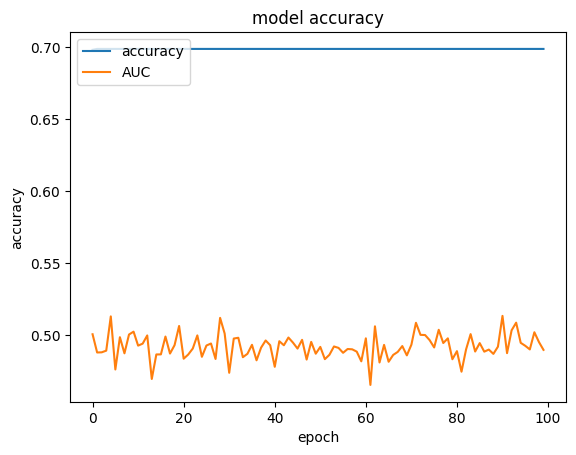

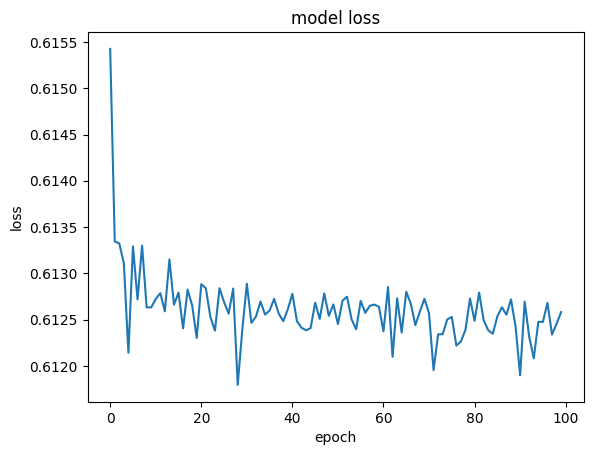

In [221]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy    
plt.plot(history.history['accuracy'])
plt.plot(history.history['auc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'AUC'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [75]:
y_pr = model.predict(X_train)
y_pr

100/100 [==============================] - 2s 14ms/step


array([[0.3592351 ],
       [0.3592351 ],
       [0.3592351 ],
       ...,
       [0.35923508],
       [0.35923508],
       [0.35923508]], dtype=float32)

In [ ]:
predictions = model.predict(X_test)
predictions = predictions[:,0]
predictions

In [ ]:
predictions = (predictions-np.min(predictions))/(np.max(predictions)-np.min(predictions))
predictions

In [ ]:
#my_functions.plt_correlation(train)

In [ ]:
from sklearn.metrics import fbeta_score

best_precision = 0
thresh = 0
for i in np.arange(0.01, 1, 0.01):
    y_pred = [1 if el > i else 0 for el in predictions]
    #precision = sklearn.metrics.accuracy_score(Y_test, y_pred) # average='weighted', beta=.5)
    precision = sklearn.metrics.fbeta_score(Y_test, y_pred, average='weighted', beta=.5)
    if best_precision < precision:
        thresh = i 
        best_precision = precision

print(best_precision)
print(thresh)

In [ ]:
y_pred = [1 if el>thresh else 0 for el in predictions]

In [ ]:
from sklearn.metrics import confusion_matrix

def cm_analysis(
    y_true, 
    y_pred, 
    title: str,
    filename: str, 
    labels: List[str], 
    ymap=None, 
    figsize=(10,10)
) -> None:
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.

    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      title:     plot name
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.

    Returns:
        None
    """

    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.2f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.2f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    cm_perc = pd.DataFrame(cm_perc, index=labels, columns=labels)
    cm_perc.index.name = 'Actual'
    cm_perc.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm_perc, annot=annot, fmt='', linewidths=1, ax=ax)
    plt.title('\n'+title+'\n', fontsize=14)
    plt.show()


cm_analysis(Y_test, y_pred,title='asdasda',filename='cm.png',labels=[1,0])

In [ ]:
fpr_test, tpr_test, _ = sklearn.metrics.roc_curve(Y_test, predictions)
auc_test = sklearn.metrics.auc(fpr_test, tpr_test)
print(auc_test)
#skplt.metrics.plot_roc(df_test['signal'],y_probas, title=f"ROC curve, AUC=test: {auc_test:.4f}", classes_to_plot=[1], figsize=(10,10))
#plt.show()

In [ ]:
df.head()

In [ ]:
close_prices = df['price_close']
values = close_prices.values
training_data_len = int(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]



x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [ ]:

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

print(np.shape(x_train), np.shape(y_train))

In [ ]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
print(np.shape(x_train), np.shape(y_train))

test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

print(np.shape(x_test), np.shape(y_test))

In [ ]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.summary()

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

In [ ]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

In [ ]:
data = df.filter(['price_close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['price_close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
import numpy as np

# Assume your DataFrame is called df

# Step 1: Convert DataFrame to a numpy array
data = np.array(df[features])

# Step 2: Define the window size, i.e., the number of time steps to look back
window_size = 50

# Step 3: Create empty lists to hold the inputs and outputs
X = []
y = df['signal'][window_size:]

# Step 4: Loop through the data and create the inputs and outputs
for i in range(window_size, len(data)):
    X.append(data[i-window_size:i])
#    y.append(data[len(features)-1][0])  # use the close price as the output variable

# Step 5: Convert the lists to numpy arrays
X = np.array(X)
y = np.array(y)

# Step 6: Reshape the input data into a 3D tensor
X = np.reshape(X, (X.shape[0], X.shape[1], len(features)))
X2 = np.transpose(X, (0, 2,1))
print(np.shape(X), np.shape(y))
print(np.shape(X2))




In [ ]:
y

In [ ]:
from keras.layers.core import Dense, Flatten, Dropout
from keras.optimizers import Adagrad


model = Sequential()
model.add(LSTM(200, return_sequences=True, activation='relu', input_shape=(X2.shape[1],X2.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mean_squared_error',
              optimizer='rmsprop',    
              metrics=['accuracy']
            )

model.summary()

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X2, y, batch_size= 1, epochs=3)

In [ ]:
y_test = model.predict(X2)

In [ ]:
y_test